# Setting up our Notebook

In [1]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
import time

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# SARIMAX Modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
import statsmodels
import seaborn as sns

# For serialization:
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings("ignore")

# SARIMAX Modeling on Price Change for BTC

## Importing and Visualization

In [2]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [3]:
# Reading in the data for initial visualization and analysis

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

six_month_date='2021-07-02 11:00:00'

Text(0.5, 1.0, 'BTC Price')

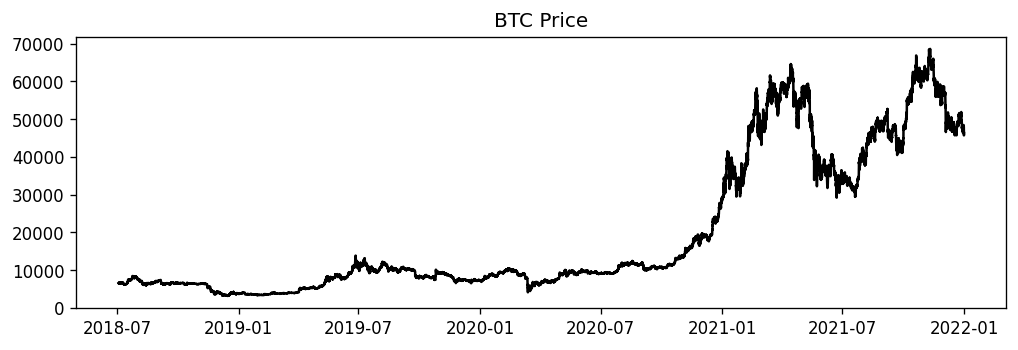

In [4]:
# Plotting our BTC Price

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Close'], color='black')
plt.title('BTC Price')

Text(0.5, 1.0, 'BTC Price Change')

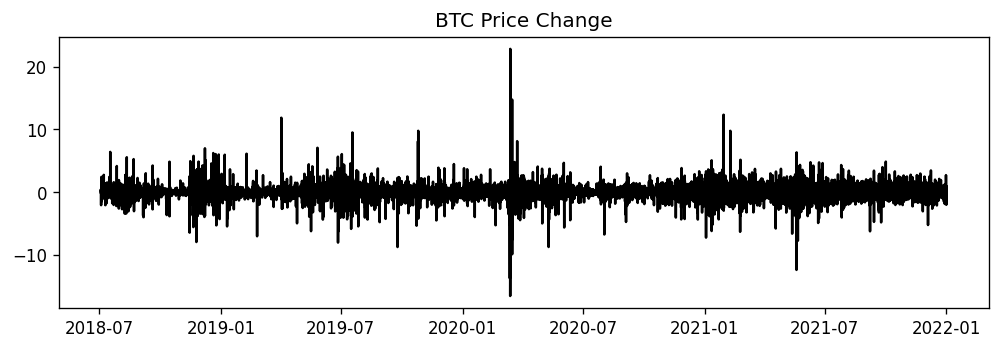

In [5]:
# Plotting our BTC Price

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Percent Change'], color='black')
plt.title('BTC Price Change')

Text(0.5, 1.0, 'BTC Price Change Training Data')

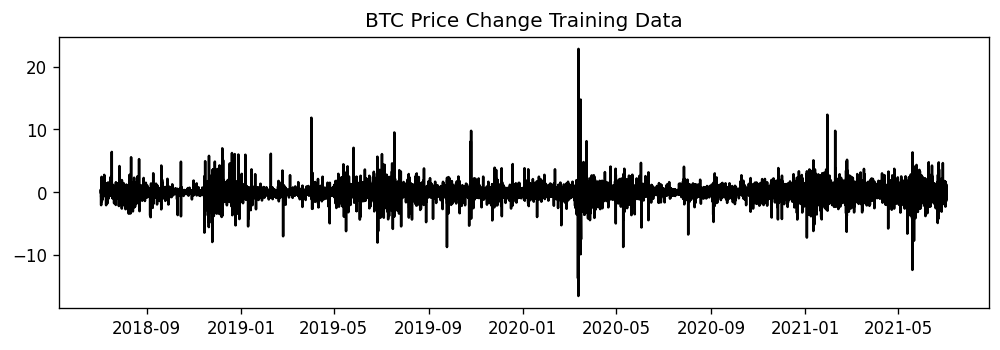

In [6]:
# Plotting our BTC Price

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Percent Change'][:'2021-07-02 11:00:00'], color='black')
plt.title('BTC Price Change Training Data')

Text(0.5, 1.0, 'BTC Price Change Testing Data')

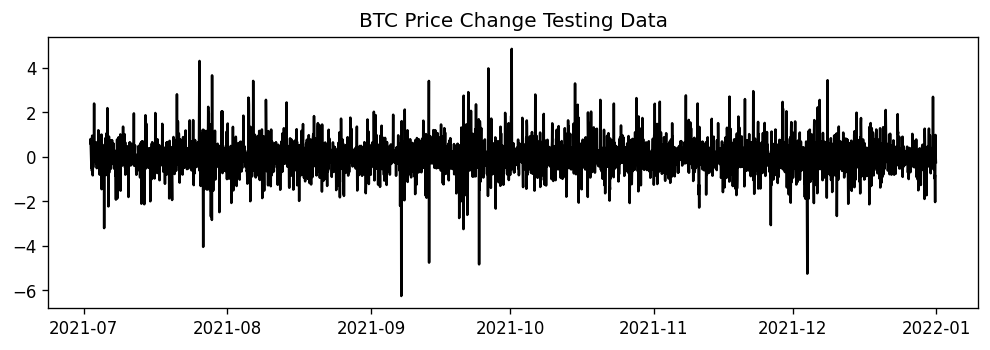

In [7]:
# Plotting our BTC Price

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Percent Change']['2021-07-02 11:00:00':], color='black')
plt.title('BTC Price Change Testing Data')

Note: This section strongly follows the following guide https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ and https://towardsai.net/p/machine-learning/stock-price-change-forecasting-with-time-series-sarimax

## Manually setting up a model

### Parameters of the ARIMA model

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

### Differencing to Determine d

To begin, we need to determine whether or not to difference the data to make it more stationary. This will give us our parameter '"d".

We will use the Augmented Dickey Fuller Test to see if d should be anything other than 0, nothing that by looking at only the price change, we already have a difference of 1.

In [8]:
result = adfuller(X['Percent Change']['2021-07-02 11:00:00':])
print('ADF Statistic for BTC Percent Change is '+str(result[0]))
print('p-value for BTC Closing Values is ' +str(result[1]))
print('\n')

ADF Statistic for BTC Percent Change is -64.75818353224876
p-value for BTC Closing Values is 0.0




We see that the data is stationary, so we will turn off differencing in the Auto-SARIMAX

### Auto-Correlation Plot to determine MA(q)

[]

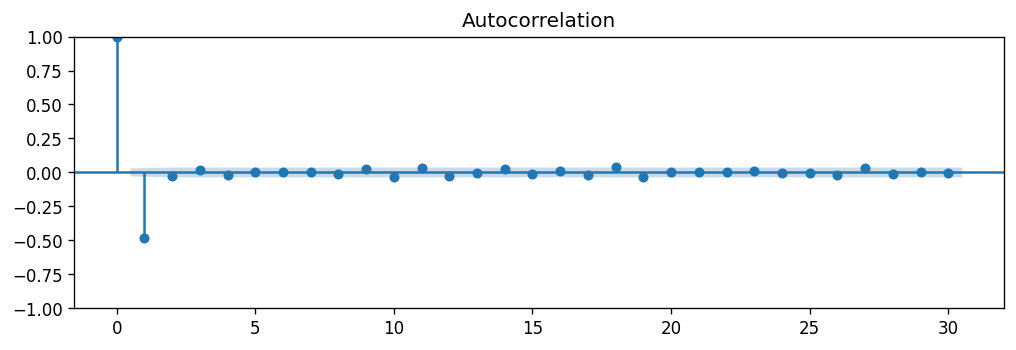

In [9]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})

plot_acf(X['Percent Change']['2021-07-02 11:00:00':].diff().dropna(), lags=30)
plt.plot()

There seems to be a significant spike at q=1 and potentially at 24, signaling possible seasonality.

### Partial Autocorrelation plot to determine AR(p)

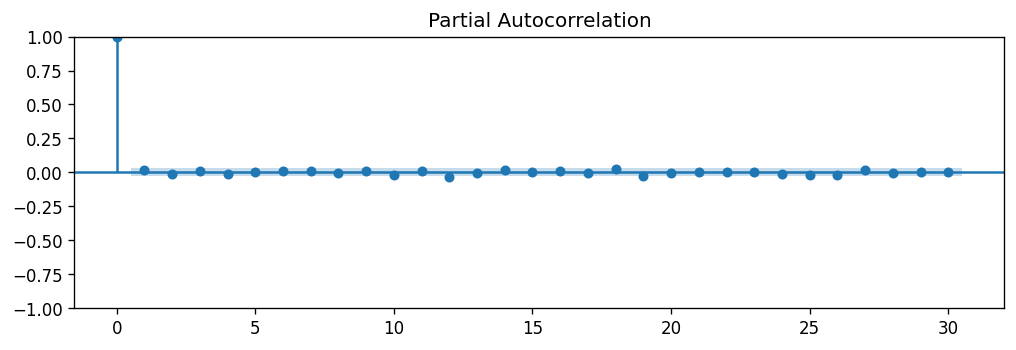

In [10]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plot_pacf(X['Percent Change']['2021-07-02 11:00:00':].dropna(), lags=30)
plt.show()

There seems to be a no real spike except at 24, possibly signaling seasonality.

Our data has negative values, so Multiplicative Decomposition is not appropriate

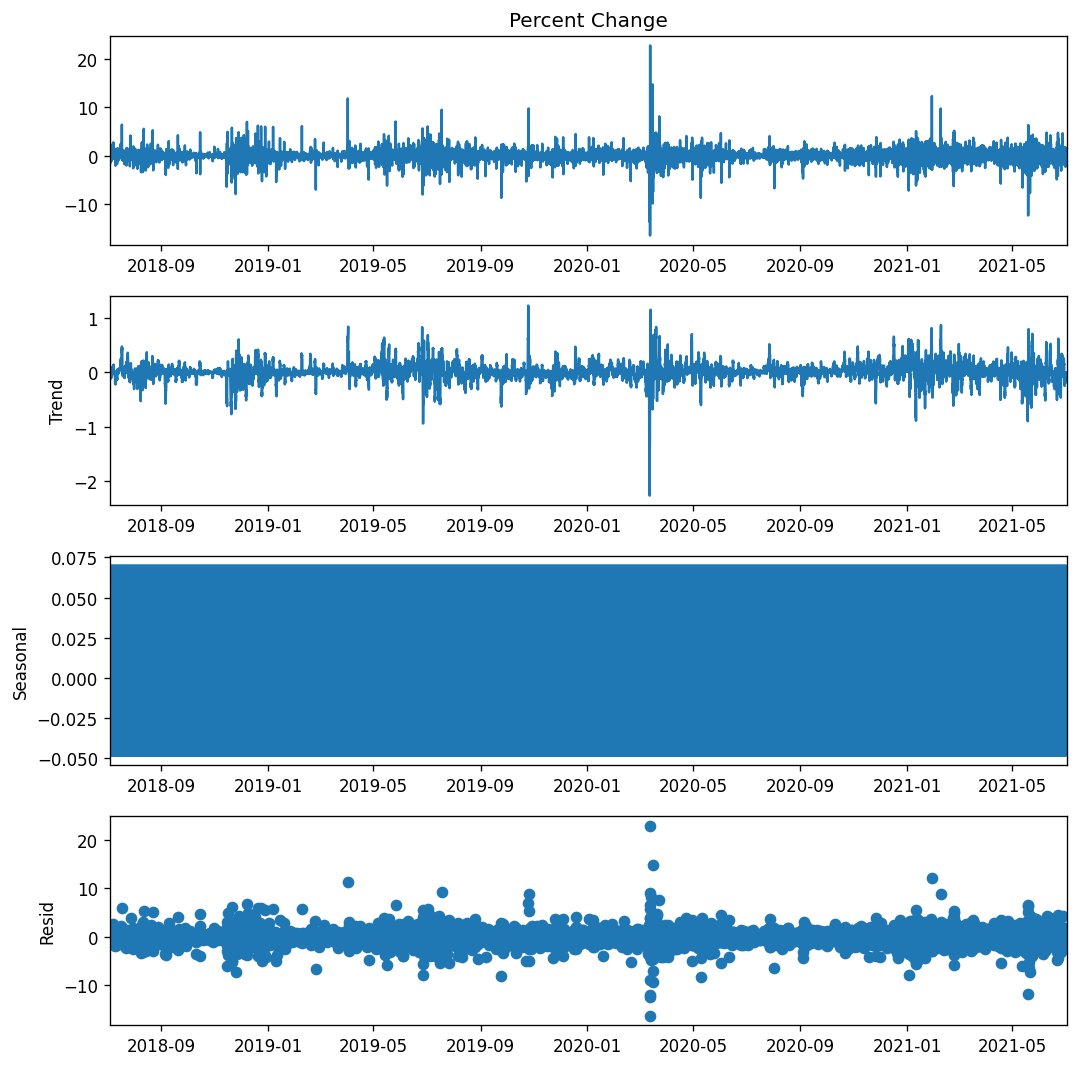

In [11]:
## from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Additive Decomposition
additive_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(X['Percent Change'][:'2021-07-02 11:00:00'],
                                                                     model='additive')

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

plt.show()

Importantly, we see no trend, so the $A(t)$ term we will keep as 0.

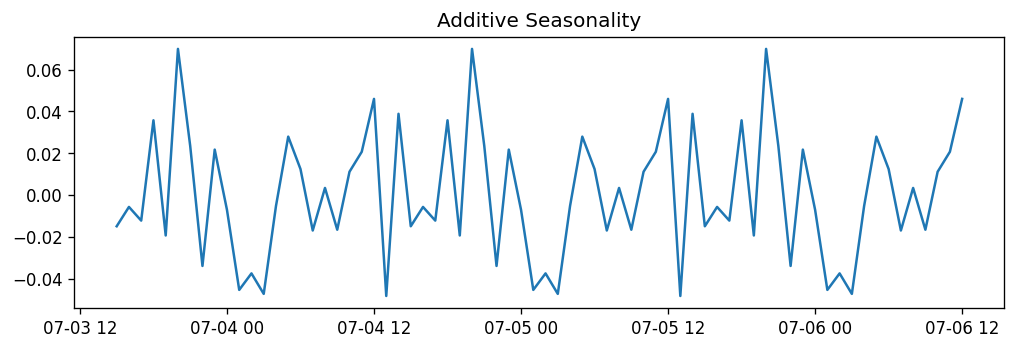

In [12]:
# Plotting seasonlity

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
add_season=additive_decomposition.seasonal[0:70]
plt.plot(add_season)
plt.title('Additive Seasonality')
plt.show()

Though it is hard to see in the original plot, on a shorter scale, we can find seasonaility in the 24-hour time-frame period.

## Auto-SARIMAX

### Data Preparation

In [4]:
# Defining a function to create PCA matrices

def PCA_creation_train_test(no_components, X_train, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling X_test 
    X_test=scaler.transform(X_test)

    # Transforming X_test
    X_test=pca.transform(X_test)
    
    return X_train, X_test

In [5]:
y=X['Percent Change']

X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)

print(X.columns)

# Removing the testing data
X_test=X[-4380:].astype('float32') # Getting the last 6 months as the testing data
y_test=y[-4380:].astype('float32')

X=X[:-4380].astype('float32') # Getting everything but the first 6 months as the training data
y=y[:-4380].astype('float32')

X_train, X_test=PCA_creation_train_test(20, X, X_test)
y_train=y

Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


### Auto-SARIMAX

In [15]:
# # We must set the 'stationary' to True, as our data is already stationary and d=0
# auto_model = auto_arima(y_train, exogenous=X_train,
#                         m=24, seasonal=True, suppress_warnings = True,  step_wise=False, trace=True,
#                        stationary=True)

# auto_model.summary()

From auto-SARIMAX run on the clusters we find the best model, by lowest AIC, is ARIMA(2,0,2)(1,0,1)[24] intercept. Total fit time: 16781.847 seconds. AIC=65433.691

### SARMAX with the best parameters identified by Auto-SARIMAX

#### Training

In [6]:
start=time.time()
model = SARIMAX(endog=y_train, exog=X_train, 
                order=(2, 0, 2),seasonal_order=(1, 0, 1, 24))
model = model.fit(disp=False)
model.summary()
end=time.time()
print('This SARMAX training took', end-start)

This SARMAX training took 1025.6131896972656


#### Diagnostics

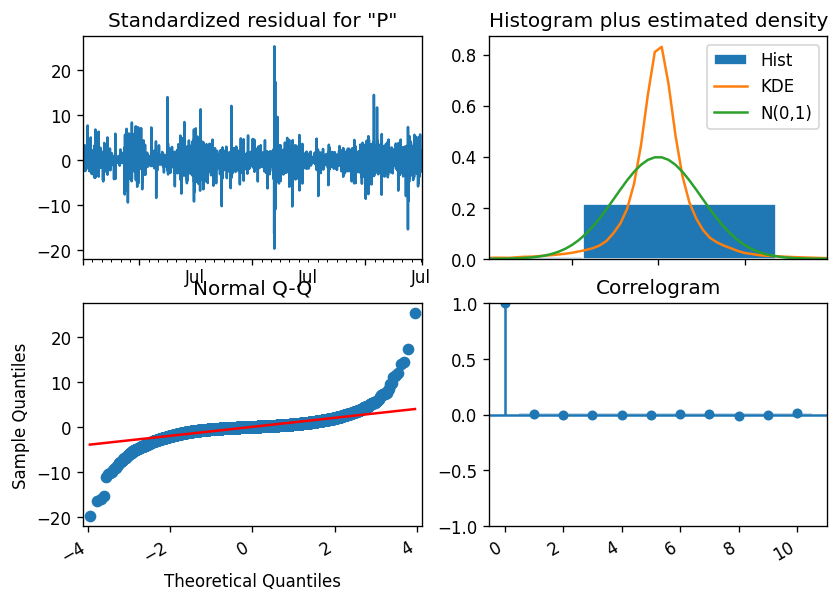

In [17]:
model.plot_diagnostics(figsize=(8,6))
plt.gcf().autofmt_xdate()
plt.show()

### Out-Of-Sample Forecasting

In [18]:
result = model.predict(start=len(X), end=len(X)+len(X_test)-1, exog=X_test.astype(float))

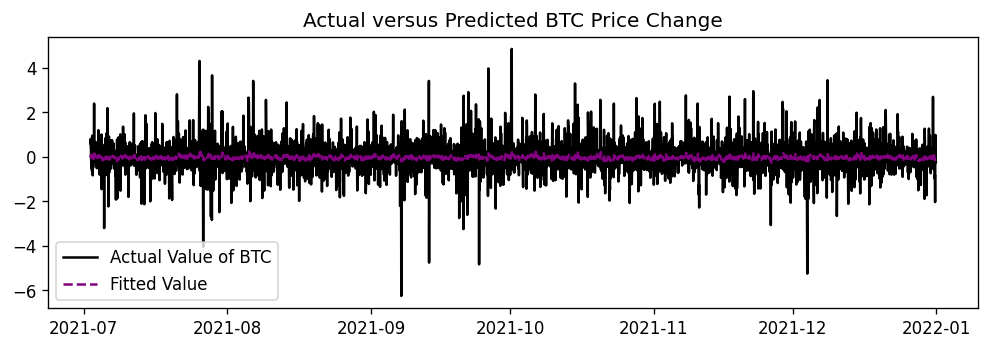

In [19]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(y_test, label='Actual Value of BTC', color='black')
plt.plot(result, label='Fitted Value', color='purple', linestyle='--')
plt.title('Actual versus Predicted BTC Price Change')
plt.legend()

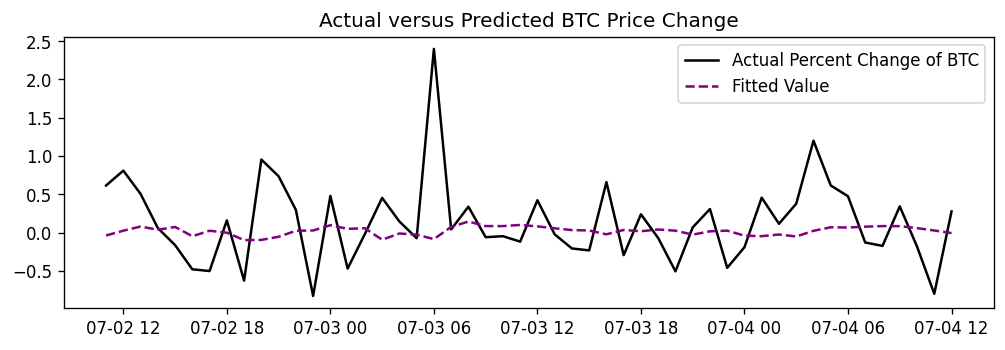

In [20]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(y_test[0:50], label='Actual Percent Change of BTC', color='black')
plt.plot(result[0:50], label='Fitted Value', color='purple', linestyle='--')
plt.title('Actual versus Predicted BTC Price Change')
plt.legend()

### Saving and Reloading the Model

In [7]:
# Save the model

model.save('Models/BTC 1H SARIMAX.pkl')

In [ ]:
# Reload the model

model=SARIMAXResults.load('Models/BTC 1H SARIMAX.pkl')